In [212]:
from DiscEvolution.grid import Grid
from DiscEvolution.star import SimpleStar
from DiscEvolution.dust import DustGrowthTwoPop
from DiscEvolution.eos import SimpleDiscEOS, ChambersEOS, LocallyIsothermalEOS
from DiscEvolution.viscous_evolution import LBP_Solution, ViscousEvolution
from DiscEvolution.disc_winds import DiskWindEvolution
from DiscEvolution.constants import Msun, AU, yr

import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'

In [213]:
def chambers_model(**kwargs):

    init_params = {"sigma0":3450,
                "r0":1, 
                "T0":150, 
                "v0":30,
                "fw":0,
                "K":0, 
                "alpha_turb":None,
                "alpha_wind":None,
                "Tevap":1500, 
                "rexp":15,
                "k0":0.1,
                "rmin":0.05,
                "rmax":1000,
                "nr":1000,
                "initial_frac":0.01}
    
    init_params.update(kwargs)

    grid = Grid(init_params['rmin'], init_params['rmax'], init_params['nr'])
    star = SimpleStar()
    wind = DiskWindEvolution(star, init_params['sigma0'],init_params['r0'],init_params['T0'],
                            init_params['v0'],init_params['fw'],
                            init_params['K'],init_params['Tevap'],
                            init_params['rexp'],init_params['k0'])
    
    eos = ChambersEOS(star, init_params['sigma0'],init_params['r0'],init_params['T0'],
                            init_params['v0'],init_params['fw'],
                            init_params['K'],init_params['Tevap'],
                            init_params['rexp'],init_params['k0'])
    
    if init_params['alpha_turb']:
        wind.calculate_chambers_params(init_params['alpha_turb'], init_params['alpha_wind'], set=True)
        eos.update_params(wind)
    eos.set_grid(grid)
    
    Sigma = wind(grid.Rc, 0)[0]
    Mdot = wind(grid.Rc, 0)[3]
    disc = DustGrowthTwoPop(grid, star, eos, 0.01, Sigma)

    return disc.Sigma_G, disc.T, grid.Rc, Mdot

In [214]:
def LBP_model(**kwargs):

    init_params = {"alpha":1e-3, "rmin":0.05, "rmax":1000, "nr":1000, "Mdot":1e-8}
    init_params.update(kwargs)

    alpha = init_params['alpha']

    grid = Grid(init_params['rmin'], init_params['rmax'], init_params['nr'])
    star = SimpleStar()

    Mdot  = init_params["Mdot"]
    Rd    = 100
    R = grid.Rc
    Mdot *= (Msun / yr) / AU**2

    eos = SimpleDiscEOS(star, alpha)

    Sigma = (Mdot / (0.1 * alpha * R**2 * star.Omega_k(R))) * np.exp(-R/Rd)
    # eos = LocallyIsothermalEOS(star, 1 / 30., -0.25, init_params['alpha'])
    
    eos.set_grid(grid)
    eos.update(0, Sigma)
    for i in range(100):
        Sigma = 0.5 * (Sigma + (Mdot / (3 * np.pi * eos.nu)) * np.exp(-R/Rd))
        eos.update(0, Sigma)

    M = 1e-2*Msun
    # Rd = 30
    nud = np.interp(Rd, grid.Rc, eos.nu)
    LBP = LBP_Solution(M, Rd, nud, 1)
    gas = ViscousEvolution()
    Sigma = LBP(grid.Rc, 0.)/AU**2
    # eos.update(0, Sigma)
    
    disc = DustGrowthTwoPop(grid, star, eos, 0.01, Sigma)
    v_visc = gas.viscous_velocity(disc, Sigma)
    Mdot = disc.Mdot(v_visc)[0]

    return disc.Sigma, disc.T, grid.Rc, gas, Mdot

Chambers accretion rate: 1.1754504516126683e-07 Msun/yr
LBP accretion rate: -7.650230517475831e-07 Msun/yr


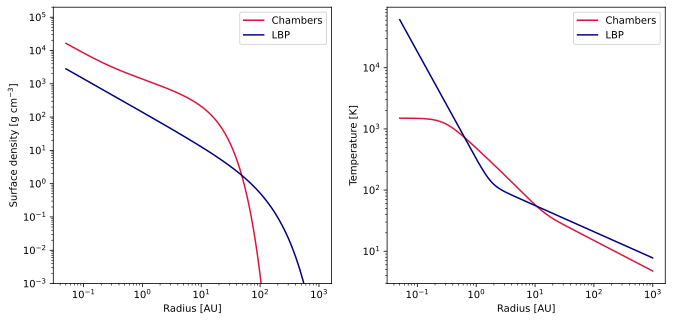

In [215]:
# Sigma_C, T_C, Rc_C = chambers_model(sigma0=1.2e3, fw=0, K=0)
# Sigma_C, T_C, Rc_C, Mdot_C = chambers_model(sigma0=1800, alpha_turb=1e-3, alpha_wind=0)
Sigma_C, T_C, Rc_C, Mdot_C = chambers_model(sigma0=1400)
Sigma_LBP, T_LBP, Rc_LBP, gas, Mdot_LBP = LBP_model(alpha=1e-2, Mdot=1e-8)

fig, ax = plt.subplots(1,2, figsize = (11,5))

# for t in np.array([0,0.1,1,2,3])*1e6:
ax[0].loglog(Rc_C, Sigma_C, label = "Chambers", color = "Crimson")
ax[0].loglog(Rc_LBP, Sigma_LBP, label = "LBP", color = "navy")
ax[0].set_ylim(1e-3, 2e5)
ax[0].set_xlabel("Radius [AU]")
ax[0].set_ylabel("Surface density [g cm$^{-3}$]")
ax[0].legend()

ax[1].loglog(Rc_C, T_C, label = "Chambers", color = "crimson")
ax[1].loglog(Rc_LBP, T_LBP, label = "LBP", color = "navy")
ax[1].set_xlabel("Radius [AU]")
ax[1].set_ylabel("Temperature [K]")
ax[1].legend()

print("Chambers accretion rate:", Mdot_C, "Msun/yr")
print("LBP accretion rate:", Mdot_LBP, "Msun/yr")